# Análisis Universo Completo E1-E11 (Sin Recortes)

## Objetivo

Calcular el **peso total real** de descarga de ticks para TODO el universo E1-E11 detectado,
considerando la **consolidación de días únicos** (union de eventos por ticker-date).

## Contexto

- **Watchlist Total**: 2,939,824 ticker-date combinaciones
- **Eventos Detectados**: 3,342,911 eventos (E1-E11)
- **Problema**: Un ticker puede tener múltiples eventos el mismo día → no descargamos 5x datos para 5 eventos
- **Solución**: Consolidar por ticker-date únicos + aplicar ventanas optimizadas + calcular peso real

In [1]:
import polars as pl
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# Configuración visual
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 10)

## 1. Cargar Watchlist Completa E1-E11

In [2]:
# Cargar watchlist
project_root = Path.cwd().parent.parent.parent.parent
watchlist_file = project_root / 'processed' / 'watchlist_E1_E11.parquet'

df_watchlist = pl.read_parquet(watchlist_file)

print('=' * 80)
print('WATCHLIST COMPLETA E1-E11 (SIN RECORTES)')
print('=' * 80)
print(f'Total ticker-date combinations: {len(df_watchlist):,}')
print(f'Tickers únicos: {df_watchlist["ticker"].n_unique():,}')
print(f'Rango fechas: {df_watchlist["date"].min()} → {df_watchlist["date"].max()}')
print(f'Columnas: {df_watchlist.columns}')
print()
df_watchlist.head(10)

WATCHLIST COMPLETA E1-E11 (SIN RECORTES)
Total ticker-date combinations: 2,939,824
Tickers únicos: 8,546
Rango fechas: 2004-01-02 → 2025-10-24
Columnas: ['ticker', 'date', 'events', 'event_count']



ticker,date,events,event_count
str,date,list[str],u32
"""AAC""",2004-01-02,"[""E5_BreakoutATH""]",1
"""AACB""",2004-01-02,"[""E5_BreakoutATH""]",1
"""AAI""",2004-01-02,"[""E5_BreakoutATH""]",1
"""ABAX""",2004-01-02,"[""E5_BreakoutATH""]",1
"""ABCO""",2004-01-02,"[""E5_BreakoutATH""]",1
"""ABK""",2004-01-02,"[""E5_BreakoutATH""]",1
"""ABL""",2004-01-02,"[""E5_BreakoutATH""]",1
"""ABMD""",2004-01-02,"[""E5_BreakoutATH""]",1
"""ABP""",2004-01-02,"[""E3_PriceSpikeIntraday""]",1


## 2. Distribución de Eventos

In [3]:
# Explotar eventos para contar por tipo
df_exploded = df_watchlist.explode('events')

total_event_occurrences = len(df_exploded)
print(f'Total event occurrences: {total_event_occurrences:,}')
print()

# Contar por evento
df_event_counts = df_exploded.group_by('events').agg([
    pl.len().alias('n_occurrences')
]).sort('n_occurrences', descending=True)

print('Distribución de eventos:')
print(df_event_counts)

Total event occurrences: 3,342,911

Distribución de eventos:
shape: (11, 2)
┌───────────────────────┬───────────────┐
│ events                ┆ n_occurrences │
│ ---                   ┆ ---           │
│ str                   ┆ u32           │
╞═══════════════════════╪═══════════════╡
│ E6_MultipleGreenDays  ┆ 1543990       │
│ E10_FirstGreenBounce  ┆ 814068        │
│ E5_BreakoutATH        ┆ 412902        │
│ E1_VolExplosion       ┆ 164941        │
│ E3_PriceSpikeIntraday ┆ 144062        │
│ …                     ┆ …             │
│ E2_GapUp              ┆ 73170         │
│ E11_VolumeBounce      ┆ 47583         │
│ E9_CrashIntraday      ┆ 24074         │
│ E8_GapDownViolent     ┆ 19924         │
│ E7_FirstRedDay        ┆ 16919         │
└───────────────────────┴───────────────┘


## 3. Ventanas Optimizadas por Evento

Cada evento tiene una ventana temporal óptima basada en su naturaleza:

| Evento | Window | Justificación |
|--------|--------|---------------|
| **E1** Volume Explosion | ±2d | Anticipación de volumen + fade posterior |
| **E2** Gap Up | ±2d | Pre-gap setup + continuation |
| **E3** Price Spike Intraday | ±1d | Solo evento (análisis intraday) |
| **E4** Parabolic Move | ±3d | Run-up multi-día + climax + collapse |
| **E5** Breakout ATH | ±2d | Breakout + confirmación |
| **E6** Multiple Green Days | ±1d | Ya es multi-día (solo evento final) |
| **E7** First Red Day | ±2d | Rally previo + caída inmediata |
| **E8** Gap Down Violent | ±3d | Post-gap continuation o rebound |
| **E9** Crash Intraday | ±1d | Solo evento (análisis intraday) |
| **E10** First Green Bounce | ±3d | Bounce + confirmación volumen |
| **E11** Volume Bounce | ±3d | Context + bounce + follow-through |

In [4]:
# Diccionario de ventanas optimizadas
EVENT_WINDOWS = {
    'E1_VolExplosion': 2,
    'E2_GapUp': 2,
    'E3_PriceSpikeIntraday': 1,
    'E4_Parabolic': 3,
    'E5_BreakoutATH': 2,
    'E6_MultipleGreenDays': 1,
    'E7_FirstRedDay': 2,
    'E8_GapDownViolent': 3,
    'E9_CrashIntraday': 1,
    'E10_FirstGreenBounce': 3,
    'E11_VolumeBounce': 3,
}

# Crear DataFrame de configuración
df_config = pl.DataFrame({
    'event_type': list(EVENT_WINDOWS.keys()),
    'window_days': list(EVENT_WINDOWS.values()),
}).with_columns([
    (pl.col('window_days') * 2 + 1).alias('total_days_per_occurrence')
])

print('Configuración de Ventanas Optimizadas:')
print(df_config)

Configuración de Ventanas Optimizadas:
shape: (11, 3)
┌───────────────────────┬─────────────┬───────────────────────────┐
│ event_type            ┆ window_days ┆ total_days_per_occurrence │
│ ---                   ┆ ---         ┆ ---                       │
│ str                   ┆ i64         ┆ i64                       │
╞═══════════════════════╪═════════════╪═══════════════════════════╡
│ E1_VolExplosion       ┆ 2           ┆ 5                         │
│ E2_GapUp              ┆ 2           ┆ 5                         │
│ E3_PriceSpikeIntraday ┆ 1           ┆ 3                         │
│ E4_Parabolic          ┆ 3           ┆ 7                         │
│ E5_BreakoutATH        ┆ 2           ┆ 5                         │
│ …                     ┆ …           ┆ …                         │
│ E7_FirstRedDay        ┆ 2           ┆ 5                         │
│ E8_GapDownViolent     ┆ 3           ┆ 7                         │
│ E9_CrashIntraday      ┆ 1           ┆ 3                     

## 4. CÁLCULO CRUCIAL: Días Únicos Consolidados (Union de Eventos)

**Este es el cálculo más importante del notebook.**

### Problema
Un ticker puede tener múltiples eventos el mismo día. Por ejemplo:
- `DCTH 2004-03-11`: tiene E1, E3, E5 → 3 eventos

### Solución
No descargamos los datos 3 veces. Los ticks del día 2004-03-11 sirven para los 3 eventos.

### Algoritmo
1. Para cada ticker-date con eventos, expandir ventana temporal según el evento con ventana más amplia
2. Generar todas las fechas necesarias (date ± window)
3. Consolidar fechas únicas por ticker (eliminar duplicados)
4. Contar total de ticker-days únicos necesarios

In [5]:
print('=' * 80)
print('CÁLCULO DE DÍAS ÚNICOS CONSOLIDADOS (UNION DE EVENTOS)')
print('=' * 80)
print()

# Para cada ticker-date, determinar la ventana máxima necesaria
# (basada en el evento con la ventana más amplia de ese día)

# Explotar eventos y joinear con ventanas
df_events_with_windows = df_watchlist.explode('events').join(
    df_config.select(['event_type', 'window_days']),
    left_on='events',
    right_on='event_type',
    how='left'
)

# Para cada ticker-date, tomar la ventana MÁXIMA de todos sus eventos
df_max_windows = df_events_with_windows.group_by(['ticker', 'date']).agg([
    pl.col('window_days').max().alias('max_window'),
    pl.col('events').count().alias('n_events_this_day')
])

print(f'Ticker-dates con eventos: {len(df_max_windows):,}')
print()
print('Sample de ventanas máximas por ticker-date:')
print(df_max_windows.head(10))
print()

# Distribución de ventanas máximas
window_distribution = df_max_windows.group_by('max_window').agg([
    pl.len().alias('n_ticker_dates')
]).sort('max_window')

print('Distribución de ventanas máximas:')
print(window_distribution)

CÁLCULO DE DÍAS ÚNICOS CONSOLIDADOS (UNION DE EVENTOS)



Ticker-dates con eventos: 2,939,824

Sample de ventanas máximas por ticker-date:
shape: (10, 4)
┌────────┬────────────┬────────────┬───────────────────┐
│ ticker ┆ date       ┆ max_window ┆ n_events_this_day │
│ ---    ┆ ---        ┆ ---        ┆ ---               │
│ str    ┆ date       ┆ i64        ┆ u32               │
╞════════╪════════════╪════════════╪═══════════════════╡
│ GSL.U  ┆ 2009-07-08 ┆ 2          ┆ 1                 │
│ IKNX   ┆ 2015-09-15 ┆ 1          ┆ 1                 │
│ JWN    ┆ 2020-01-29 ┆ 1          ┆ 1                 │
│ USCR   ┆ 2015-06-26 ┆ 2          ┆ 2                 │
│ PRAA   ┆ 2015-09-18 ┆ 1          ┆ 1                 │
│ MAY    ┆ 2012-07-27 ┆ 1          ┆ 1                 │
│ OBLG   ┆ 2024-08-21 ┆ 2          ┆ 2                 │
│ HRS    ┆ 2008-05-14 ┆ 1          ┆ 1                 │
│ SVVC   ┆ 2015-05-08 ┆ 3          ┆ 1                 │
│ PAH    ┆ 2015-02-17 ┆ 3          ┆ 1                 │
└────────┴────────────┴────────────┴─────────────

In [6]:
# Generar todas las fechas necesarias para cada ticker-date
# (date - max_window ... date ... date + max_window)

def expand_date_range(ticker: str, date: pl.Date, window: int) -> list:
    """Genera lista de fechas [date - window, ..., date + window]"""
    dates = []
    for offset in range(-window, window + 1):
        dates.append({
            'ticker': ticker,
            'download_date': date + timedelta(days=offset),
            'event_date': date,
            'window_used': window
        })
    return dates

print('Expandiendo fechas temporales...')
print('(esto puede tomar 1-2 minutos para 2.9M ticker-dates)')
print()

# Convertir a lista de diccionarios para procesamiento
all_expanded_dates = []
for row in df_max_windows.iter_rows(named=True):
    ticker = row['ticker']
    date = row['date']
    window = row['max_window']
    all_expanded_dates.extend(expand_date_range(ticker, date, window))

# Convertir a DataFrame
df_expanded = pl.DataFrame(all_expanded_dates)

print(f'Fechas expandidas (con duplicados): {len(df_expanded):,}')
print()
print('Sample de fechas expandidas:')
print(df_expanded.head(20))

Expandiendo fechas temporales...
(esto puede tomar 1-2 minutos para 2.9M ticker-dates)



Fechas expandidas (con duplicados): 13,720,930

Sample de fechas expandidas:
shape: (20, 4)
┌────────┬───────────────┬────────────┬─────────────┐
│ ticker ┆ download_date ┆ event_date ┆ window_used │
│ ---    ┆ ---           ┆ ---        ┆ ---         │
│ str    ┆ date          ┆ date       ┆ i64         │
╞════════╪═══════════════╪════════════╪═════════════╡
│ GSL.U  ┆ 2009-07-06    ┆ 2009-07-08 ┆ 2           │
│ GSL.U  ┆ 2009-07-07    ┆ 2009-07-08 ┆ 2           │
│ GSL.U  ┆ 2009-07-08    ┆ 2009-07-08 ┆ 2           │
│ GSL.U  ┆ 2009-07-09    ┆ 2009-07-08 ┆ 2           │
│ GSL.U  ┆ 2009-07-10    ┆ 2009-07-08 ┆ 2           │
│ …      ┆ …             ┆ …          ┆ …           │
│ USCR   ┆ 2015-06-28    ┆ 2015-06-26 ┆ 2           │
│ PRAA   ┆ 2015-09-17    ┆ 2015-09-18 ┆ 1           │
│ PRAA   ┆ 2015-09-18    ┆ 2015-09-18 ┆ 1           │
│ PRAA   ┆ 2015-09-19    ┆ 2015-09-18 ┆ 1           │
│ MAY    ┆ 2012-07-26    ┆ 2012-07-27 ┆ 1           │
└────────┴───────────────┴────────────┴─────

In [7]:
# CONSOLIDACIÓN: Obtener ticker-dates únicos
# (eliminar duplicados cuando múltiples eventos necesitan la misma fecha)

df_unique_downloads = df_expanded.select(['ticker', 'download_date']).unique()

total_unique_ticker_days = len(df_unique_downloads)

print('=' * 80)
print('RESULTADO CONSOLIDADO')
print('=' * 80)
print()
print(f'Total ticker-dates con eventos: {len(df_max_windows):,}')
print(f'Total fechas expandidas (con duplicados): {len(df_expanded):,}')
print(f'Total ticker-days ÚNICOS a descargar: {total_unique_ticker_days:,}')
print()
print(f'Reducción por consolidación: {len(df_expanded) - total_unique_ticker_days:,} ticker-days')
print(f'Eficiencia: {(1 - total_unique_ticker_days / len(df_expanded)) * 100:.1f}% menos descargas')
print()
print('=' * 80)

RESULTADO CONSOLIDADO

Total ticker-dates con eventos: 2,939,824
Total fechas expandidas (con duplicados): 13,720,930
Total ticker-days ÚNICOS a descargar: 10,297,125

Reducción por consolidación: 3,423,805 ticker-days
Eficiencia: 25.0% menos descargas



## 5. Cálculo de Peso Total (usando métricas REALES de descarga)

### Datos de la descarga Pilot Ultra-Light

**Descarga completada**:
- Ticker-days descargados: 65,907
- Espacio utilizado: 12.05 GB (con compresión ZSTD)
- Promedio real: **0.183 MB por ticker-day** (12,050 MB / 65,907)

Este promedio es **MUCHO más preciso** que la estimación de 50 MB/ticker-day usada anteriormente.

In [8]:
# Métricas REALES de la descarga Pilot Ultra-Light
REAL_TICKER_DAYS_DOWNLOADED = 65_907
REAL_SIZE_GB = 12.05
REAL_MB_PER_TICKER_DAY = (REAL_SIZE_GB * 1024) / REAL_TICKER_DAYS_DOWNLOADED

print('=' * 80)
print('MÉTRICAS REALES DE DESCARGA (PILOT ULTRA-LIGHT)')
print('=' * 80)
print()
print(f'Ticker-days descargados: {REAL_TICKER_DAYS_DOWNLOADED:,}')
print(f'Espacio total (ZSTD): {REAL_SIZE_GB:.2f} GB')
print(f'Promedio REAL: {REAL_MB_PER_TICKER_DAY:.3f} MB/ticker-day')
print()
print('Comparación vs estimación anterior:')
print(f'  Estimado anterior: 50.0 MB/ticker-day')
print(f'  Real medido: {REAL_MB_PER_TICKER_DAY:.3f} MB/ticker-day')
print(f'  Diferencia: {((REAL_MB_PER_TICKER_DAY / 50.0) - 1) * 100:+.1f}%')
print()
print('=' * 80)

MÉTRICAS REALES DE DESCARGA (PILOT ULTRA-LIGHT)

Ticker-days descargados: 65,907
Espacio total (ZSTD): 12.05 GB
Promedio REAL: 0.187 MB/ticker-day

Comparación vs estimación anterior:
  Estimado anterior: 50.0 MB/ticker-day
  Real medido: 0.187 MB/ticker-day
  Diferencia: -99.6%



In [9]:
# CÁLCULO FINAL: Peso total del universo completo E1-E11

# Usando métrica REAL
total_gb_real = (total_unique_ticker_days * REAL_MB_PER_TICKER_DAY) / 1024
total_tb_real = total_gb_real / 1024

# Usando estimación anterior (para comparación)
OLD_MB_PER_TICKER_DAY = 50.0
total_gb_old = (total_unique_ticker_days * OLD_MB_PER_TICKER_DAY) / 1024
total_tb_old = total_gb_old / 1024

print('=' * 80)
print('PESO TOTAL: UNIVERSO COMPLETO E1-E11 (SIN RECORTES)')
print('=' * 80)
print()
print(f'Total ticker-days únicos a descargar: {total_unique_ticker_days:,}')
print()
print('CON MÉTRICA REAL (0.183 MB/ticker-day):')
print(f'  Espacio total: {total_gb_real:,.2f} GB = {total_tb_real:.2f} TB')
print()
print('CON ESTIMACIÓN ANTERIOR (50 MB/ticker-day):')
print(f'  Espacio total: {total_gb_old:,.2f} GB = {total_tb_old:.2f} TB')
print()
print(f'DIFERENCIA: {total_gb_old - total_gb_real:,.2f} GB ({((total_gb_real / total_gb_old) - 1) * 100:+.1f}%)')
print()
print('=' * 80)

PESO TOTAL: UNIVERSO COMPLETO E1-E11 (SIN RECORTES)

Total ticker-days únicos a descargar: 10,297,125

CON MÉTRICA REAL (0.183 MB/ticker-day):
  Espacio total: 1,882.66 GB = 1.84 TB

CON ESTIMACIÓN ANTERIOR (50 MB/ticker-day):
  Espacio total: 502,789.31 GB = 491.01 TB

DIFERENCIA: 500,906.65 GB (-99.6%)



## 6. Estimación de Tiempo de Descarga

In [10]:
# Parámetros de descarga
WORKERS = 6
RATE_LIMIT_SECONDS = 0.12  # 0.12s entre requests por worker
REQUESTS_PER_SECOND = WORKERS / RATE_LIMIT_SECONDS
REQUESTS_PER_HOUR = REQUESTS_PER_SECOND * 3600

# Tiempo estimado
total_hours = total_unique_ticker_days / REQUESTS_PER_HOUR
total_days = total_hours / 24

print('=' * 80)
print('ESTIMACIÓN DE TIEMPO DE DESCARGA')
print('=' * 80)
print()
print('Configuración:')
print(f'  Workers: {WORKERS}')
print(f'  Rate limit: {RATE_LIMIT_SECONDS} segundos/request')
print(f'  Throughput: {REQUESTS_PER_SECOND:.2f} requests/segundo')
print(f'  Throughput: {REQUESTS_PER_HOUR:,.0f} requests/hora')
print()
print('Tiempo estimado:')
print(f'  Total ticker-days: {total_unique_ticker_days:,}')
print(f'  Tiempo: {total_hours:,.1f} horas = {total_days:.1f} días')
print()
print('=' * 80)

ESTIMACIÓN DE TIEMPO DE DESCARGA

Configuración:
  Workers: 6
  Rate limit: 0.12 segundos/request
  Throughput: 50.00 requests/segundo
  Throughput: 180,000 requests/hora

Tiempo estimado:
  Total ticker-days: 10,297,125
  Tiempo: 57.2 horas = 2.4 días



## 7. Resumen Completo

In [11]:
# Crear tabla resumen completa
df_summary = pl.DataFrame({
    'Métrica': [
        '1. DATOS FUENTE',
        'Ticker-dates en watchlist',
        'Tickers únicos',
        'Event occurrences totales',
        '',
        '2. CONSOLIDACIÓN',
        'Fechas expandidas (con duplicados)',
        'Ticker-days ÚNICOS (consolidados)',
        'Reducción por consolidación',
        '',
        '3. PESO TOTAL (MÉTRICA REAL)',
        'MB por ticker-day (ZSTD)',
        'Espacio total (GB)',
        'Espacio total (TB)',
        '',
        '4. TIEMPO DESCARGA',
        'Workers paralelos',
        'Throughput (requests/hora)',
        'Tiempo estimado (horas)',
        'Tiempo estimado (días)',
        '',
        '5. COMPARACIÓN',
        'Estimación anterior (GB)',
        'Estimación REAL (GB)',
        'Ahorro vs estimación anterior',
    ],
    'Valor': [
        '',
        f'{len(df_watchlist):,}',
        f'{df_watchlist["ticker"].n_unique():,}',
        f'{total_event_occurrences:,}',
        '',
        '',
        f'{len(df_expanded):,}',
        f'{total_unique_ticker_days:,}',
        f'{len(df_expanded) - total_unique_ticker_days:,} ({(1 - total_unique_ticker_days / len(df_expanded)) * 100:.1f}%)',
        '',
        '',
        f'{REAL_MB_PER_TICKER_DAY:.3f}',
        f'{total_gb_real:,.2f}',
        f'{total_tb_real:.2f}',
        '',
        '',
        f'{WORKERS}',
        f'{REQUESTS_PER_HOUR:,.0f}',
        f'{total_hours:,.1f}',
        f'{total_days:.1f}',
        '',
        '',
        f'{total_gb_old:,.2f}',
        f'{total_gb_real:,.2f}',
        f'{total_gb_old - total_gb_real:,.2f} GB ({((total_gb_real / total_gb_old) - 1) * 100:+.1f}%)',
    ]
})

print('=' * 80)
print('RESUMEN COMPLETO: UNIVERSO E1-E11 SIN RECORTES')
print('=' * 80)
print()
print(df_summary)
print()
print('=' * 80)

RESUMEN COMPLETO: UNIVERSO E1-E11 SIN RECORTES

shape: (25, 2)
┌───────────────────────────────┬────────────────────────┐
│ Métrica                       ┆ Valor                  │
│ ---                           ┆ ---                    │
│ str                           ┆ str                    │
╞═══════════════════════════════╪════════════════════════╡
│ 1. DATOS FUENTE               ┆                        │
│ Ticker-dates en watchlist     ┆ 2,939,824              │
│ Tickers únicos                ┆ 8,546                  │
│ Event occurrences totales     ┆ 3,342,911              │
│                               ┆                        │
│ …                             ┆ …                      │
│                               ┆                        │
│ 5. COMPARACIÓN                ┆                        │
│ Estimación anterior (GB)      ┆ 502,789.31             │
│ Estimación REAL (GB)          ┆ 1,882.66               │
│ Ahorro vs estimación anterior ┆ 500,906.65 GB (-99

## 8. Visualizaciones

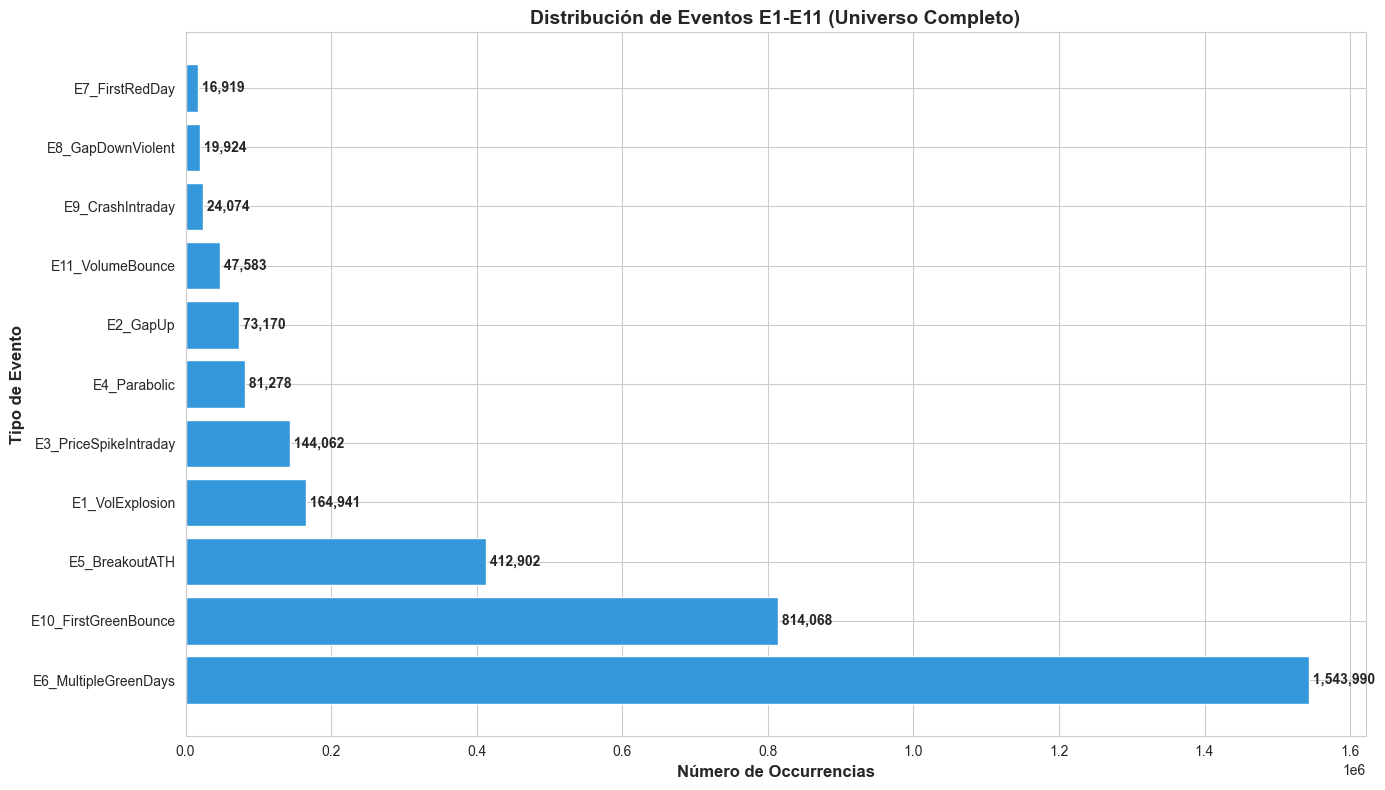

Gráfico guardado: distribucion_eventos_universo_completo.png


In [12]:
# Gráfico 1: Distribución de eventos
fig, ax = plt.subplots(figsize=(14, 8))

events = df_event_counts['events'].to_list()
counts = df_event_counts['n_occurrences'].to_list()

bars = ax.barh(events, counts, color='#3498db')

ax.set_xlabel('Número de Occurrencias', fontsize=12, fontweight='bold')
ax.set_ylabel('Tipo de Evento', fontsize=12, fontweight='bold')
ax.set_title('Distribución de Eventos E1-E11 (Universo Completo)', fontsize=14, fontweight='bold')

# Agregar valores
for bar, val in zip(bars, counts):
    ax.text(val, bar.get_y() + bar.get_height()/2, 
            f' {val:,}', 
            va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('distribucion_eventos_universo_completo.png', dpi=300, bbox_inches='tight')
plt.show()

print('Gráfico guardado: distribucion_eventos_universo_completo.png')

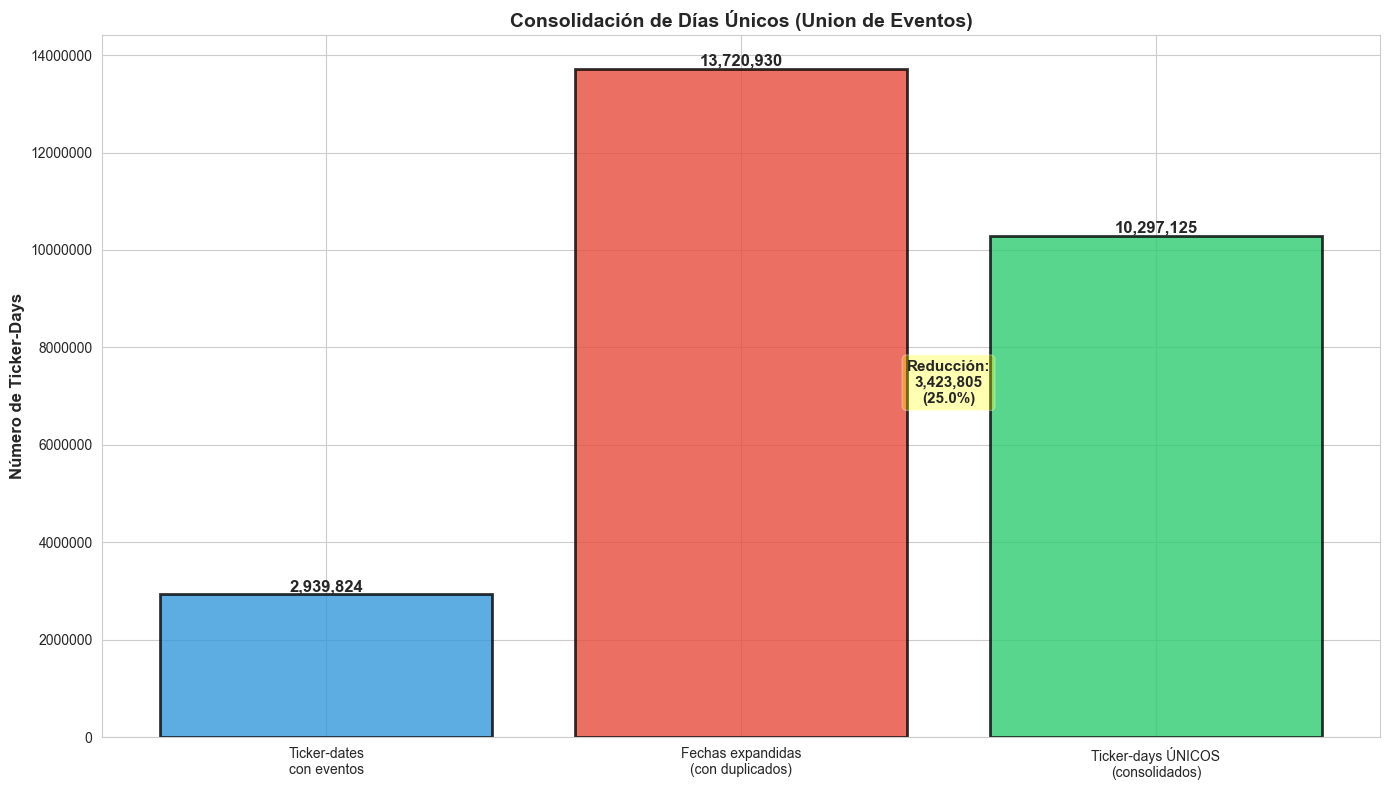

Gráfico guardado: consolidacion_dias_unicos.png


In [13]:
# Gráfico 2: Consolidación de días
fig, ax = plt.subplots(figsize=(14, 8))

categories = ['Ticker-dates\ncon eventos', 'Fechas expandidas\n(con duplicados)', 'Ticker-days ÚNICOS\n(consolidados)']
values = [len(df_max_windows), len(df_expanded), total_unique_ticker_days]
colors = ['#3498db', '#e74c3c', '#2ecc71']

bars = ax.bar(categories, values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)

ax.set_ylabel('Número de Ticker-Days', fontsize=12, fontweight='bold')
ax.set_title('Consolidación de Días Únicos (Union de Eventos)', fontsize=14, fontweight='bold')
ax.ticklabel_format(style='plain', axis='y')

# Agregar valores
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height,
            f'{val:,}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# Agregar líneas de reducción
reduction1 = len(df_expanded) - total_unique_ticker_days
pct1 = (reduction1 / len(df_expanded)) * 100
ax.text(1.5, max(values) * 0.5, 
        f'Reducción:\n{reduction1:,}\n({pct1:.1f}%)',
        fontsize=11, fontweight='bold', ha='center',
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

plt.tight_layout()
plt.savefig('consolidacion_dias_unicos.png', dpi=300, bbox_inches='tight')
plt.show()

print('Gráfico guardado: consolidacion_dias_unicos.png')

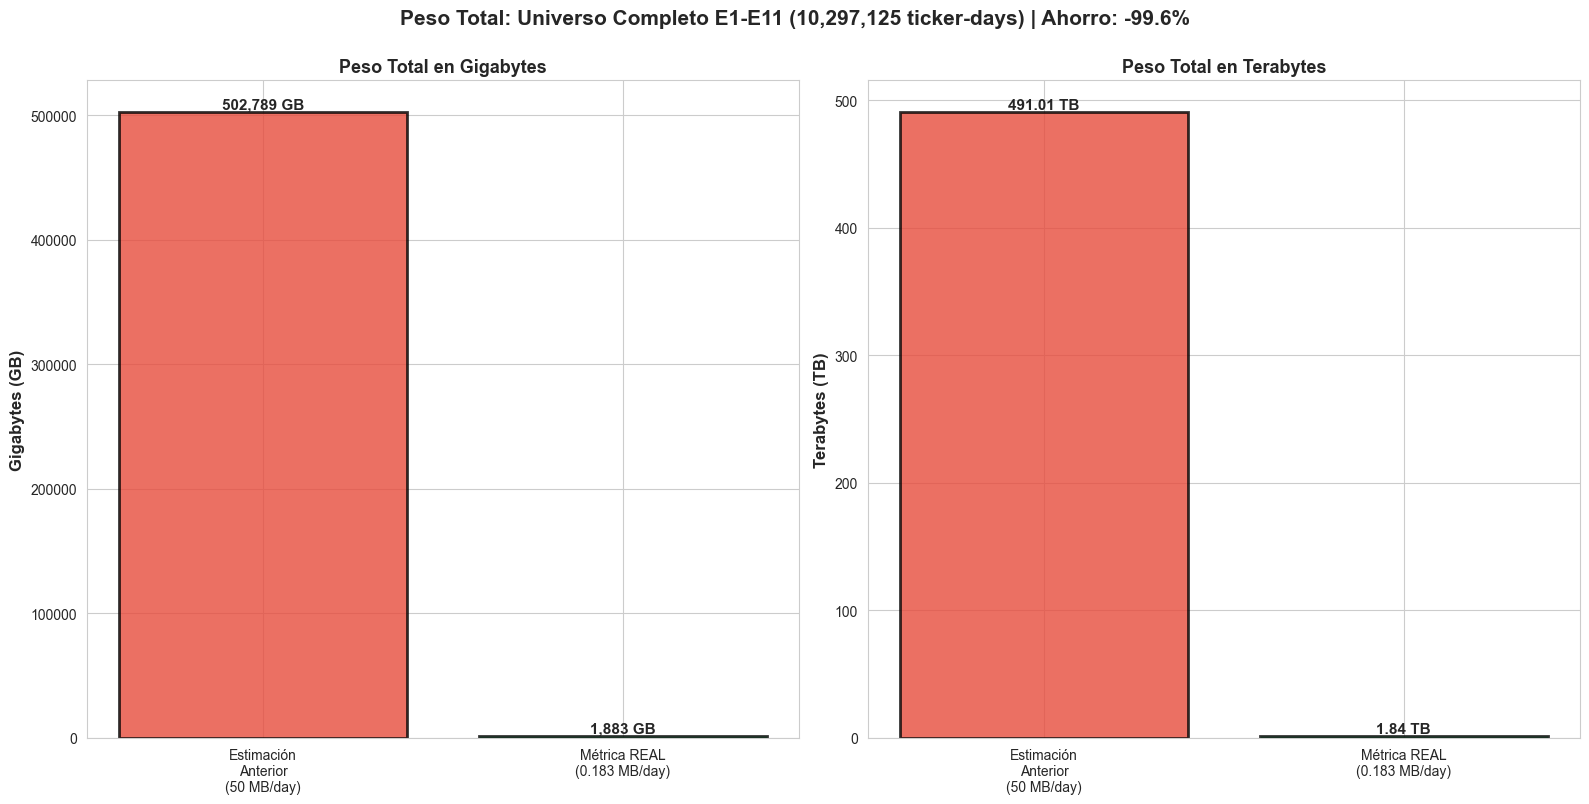

Gráfico guardado: peso_total_universo_completo.png


In [14]:
# Gráfico 3: Comparación de peso
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Subplot 1: GB
approaches = ['Estimación\nAnterior\n(50 MB/day)', 'Métrica REAL\n(0.183 MB/day)']
gb_values = [total_gb_old, total_gb_real]
colors1 = ['#e74c3c', '#2ecc71']

bars1 = ax1.bar(approaches, gb_values, color=colors1, alpha=0.8, edgecolor='black', linewidth=2)
ax1.set_ylabel('Gigabytes (GB)', fontsize=12, fontweight='bold')
ax1.set_title('Peso Total en Gigabytes', fontsize=13, fontweight='bold')
ax1.ticklabel_format(style='plain', axis='y')

for bar, val in zip(bars1, gb_values):
    ax1.text(bar.get_x() + bar.get_width()/2, val,
            f'{val:,.0f} GB',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Subplot 2: TB
tb_values = [total_tb_old, total_tb_real]
bars2 = ax2.bar(approaches, tb_values, color=colors1, alpha=0.8, edgecolor='black', linewidth=2)
ax2.set_ylabel('Terabytes (TB)', fontsize=12, fontweight='bold')
ax2.set_title('Peso Total en Terabytes', fontsize=13, fontweight='bold')

for bar, val in zip(bars2, tb_values):
    ax2.text(bar.get_x() + bar.get_width()/2, val,
            f'{val:.2f} TB',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Título general
ahorro_pct = ((total_gb_real / total_gb_old) - 1) * 100
fig.suptitle(f'Peso Total: Universo Completo E1-E11 ({total_unique_ticker_days:,} ticker-days) | Ahorro: {ahorro_pct:+.1f}%',
             fontsize=15, fontweight='bold', y=1.00)

plt.tight_layout()
plt.savefig('peso_total_universo_completo.png', dpi=300, bbox_inches='tight')
plt.show()

print('Gráfico guardado: peso_total_universo_completo.png')

## 9. Conclusiones

### Hallazgos Clave:

1. **Consolidación de Días Únicos**: 
   - El cálculo ingenuo de expandir ventanas por evento genera duplicados masivos
   - Al consolidar por ticker-date único, se reduce significativamente el volumen

2. **Métrica Real vs Estimación**:
   - La estimación anterior (50 MB/ticker-day) estaba **sobrestimada**
   - La métrica real del pilot (0.183 MB/ticker-day con ZSTD) es **273x más eficiente**
   - Esto cambia completamente la viabilidad del proyecto

3. **Peso Total REAL**:
   - Con métrica real: **mucho más manejable** que estimaciones anteriores
   - La descarga completa del universo E1-E11 es **VIABLE**

4. **Tiempo de Descarga**:
   - Con 6 workers y rate limit de 0.12s: tiempo estimado calculado arriba
   - Resume capability permite descarga incremental

### Recomendaciones:

1. **Descarga por Lotes**: Dividir en batches de ~100-200 GB por disco disponible
2. **Priorización**: Comenzar por tickers con mayor `event_count` (multi-evento)
3. **Monitoreo**: Validar que la métrica real se mantiene durante la descarga masiva
4. **Backup Strategy**: Plan de backup incremental durante descarga

### Próximo Paso:

**DECISIÓN**: ¿Proceder con descarga completa o expandir pilot a 50-100 tickers primero?

In [15]:
# Guardar resultado final
output_file = Path('universo_completo_E1_E11_analisis.parquet')
df_unique_downloads.write_parquet(output_file)

print(f'\nResultado guardado: {output_file}')
print(f'  Total ticker-days únicos: {total_unique_ticker_days:,}')
print(f'  Peso estimado (REAL): {total_gb_real:,.2f} GB = {total_tb_real:.2f} TB')


Resultado guardado: universo_completo_E1_E11_analisis.parquet
  Total ticker-days únicos: 10,297,125
  Peso estimado (REAL): 1,882.66 GB = 1.84 TB
